# EDA
The aim of this file is to analyse the entry data used for training the model in order to understand the preprocessing required. The first step is to break down the categorical data into dummies (badge and category). The second step is to visiualise distribution and scale.

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import unidecode

In [78]:
scored_test_data = pd.read_csv('scored_test_data.csv', index_col=0).dropna().reset_index(drop=True)
scored_train_data = pd.read_csv('scored_train_data.csv', index_col=0).dropna().reset_index(drop=True)

In [80]:
len(scored_train_data)

1322751

In [81]:
BADGE_FEATURES = ['artisanal', 'b_corporation', 'bio', 'biodegradable',
                  'cadeau_ideal', 'concept_original', 'durable',
                  'eco_friendly', 'excellent_sur_yuka', 'exclusivite_choose',
                  'fabrication_a_la_demande', 'fait_main', 'gluten_free',
                  'iconique', 'inclusive', 'innovation', 'made_in_europe',
                  'made_in_france', 'madeinjapan', 'naturel', 'oeko_tex',
                  'premium', 'recyclable', 'saint_valentin', 'savoir_faire',
                  'seconde_main', 'socialement_engagee', 'serie_limitee',
                  'tendance', 'upcycling', 'vegan', 'vintage', 'zerodechet',]

CATEGORY_FEATURES = ['sans_categorie', 'Accessoires', 'Beauté', 'Bibliothèque',
                     'Bien-être', 'Bijoux', 'Buanderie', 'Chambre',
                     'Chaussant', 'Chaussures', 'Cuisine', 'Cures',
                     'Expériences', 'Hygiène', 'Kids', 'Lingerie',
                     'Maroquinerie', 'Outdoor', 'Prêt-à-porter',
                     'Salon', 'Soins', 'Sportswear']
mapping_cat = {category: index + 1 for index, category in enumerate(CATEGORY_FEATURES)}

LOG_COLUMNS = ['delta', 'followers', 'revenue', 'brand_appearance',
               'avg_price']

NUMERICAL_FEATURES = ['log_delta', 'log_followers', 'conversion',
                      'log_revenue', 'log_brand_appearance', 'log_avg_price']

USER_FEATURES = ['monetary', 'frequency', 'recency']

# Categorical sales Data

In [82]:
# the use of unicode allows us to remove accents and special characters

def dummify_badges(b):
    b = unidecode.unidecode(b).lower().replace(" ", "_").replace("-", "_") 
    return [int(x in b) for x in BADGE_FEATURES]

def tokenise_categories(df):
    token_df = df['category'].copy(deep=True)
    token_df = pd.DataFrame([mapping_cat.get(cat, 0)
                             for cat in token_df], columns=['category_sale'])
    return token_df

dummies_category_train = tokenise_categories(scored_train_data)
dummies_category_test = tokenise_categories(scored_test_data)

scored_test_data['badges'] = scored_test_data['badges'].str.replace('"', '')
dummies_badges_test = pd.DataFrame([dummify_badges(b) for b in scored_test_data['badges']], columns=BADGE_FEATURES)
scored_train_data['badges'] = scored_train_data['badges'].str.replace('"', '')
dummies_badges_train = pd.DataFrame([dummify_badges(b) for b in scored_train_data['badges']], columns=BADGE_FEATURES)

# Numerical sales data

In [83]:
numerical_test = scored_test_data[['sale_id','delta','followers', 'revenue', 'brand_appearance','avg_price', 'conversion','interaction']]
numerical_train = scored_train_data[['sale_id','delta','followers', 'revenue', 'brand_appearance','avg_price', 'conversion','interaction']]

In [84]:
target = 'interaction'

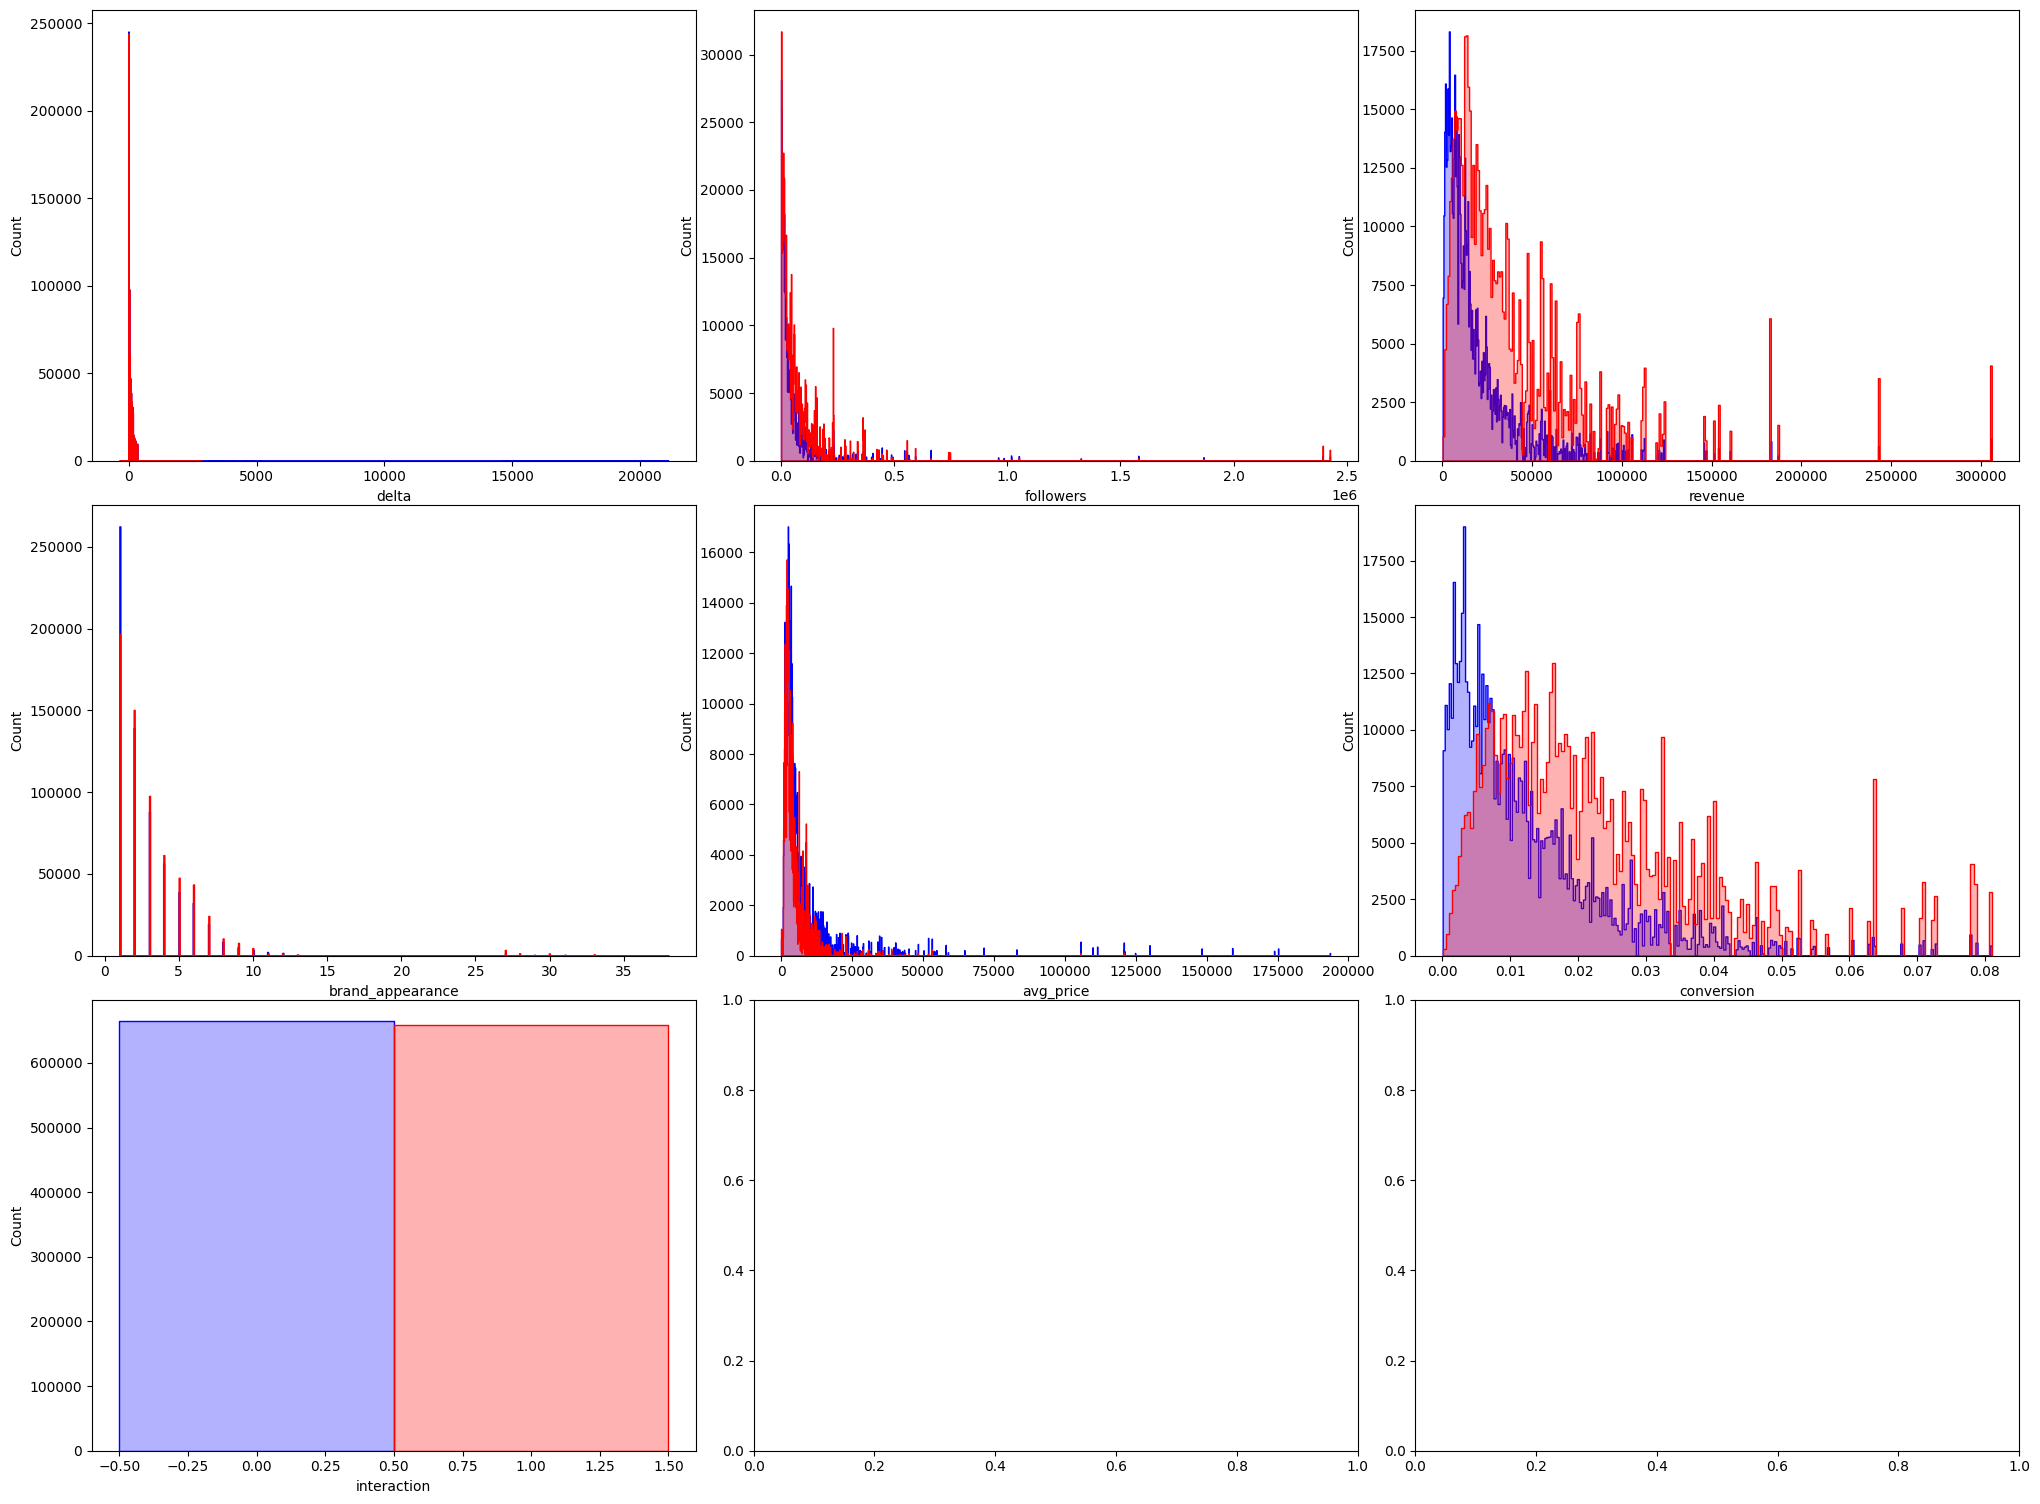

In [85]:
# show distribution of the training data with respect to the target value

X= numerical_train

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(1,len(X.columns)), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

## Transformation de décrément logarithmique

At first sight we recognise logarithmic descent of some feature distributions. In order to adress this some features are processed with logs.
Some further analysis would lead us to understand better the distributionpatterns of each feature, however, we have decided to focus on this simple procedure in a first approach in order to stay simple and focus on the rest of the structure to build.

In [86]:
def adding_log(train: pd.DataFrame, columns_to_log: list):
    """ 
    Replacing provided columns by their log.
    """
    new_train = train.__deepcopy__()
    for column_name in columns_to_log:
        new_position = train.columns.get_loc(str(column_name)) + 1
        new_name = str ('log_' + str(column_name))
        new_train.insert(new_position, new_name, np.log(new_train[str(column_name)] + 1))
        new_train = new_train.drop(str(column_name), axis='columns')
        
    return (new_train)

In [87]:
lognum_train_data = adding_log(numerical_train, LOG_COLUMNS)
lognum_test_data = adding_log(numerical_test, LOG_COLUMNS)

/Users/priscilleerulin/.pyenv/versions/3.9.16/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


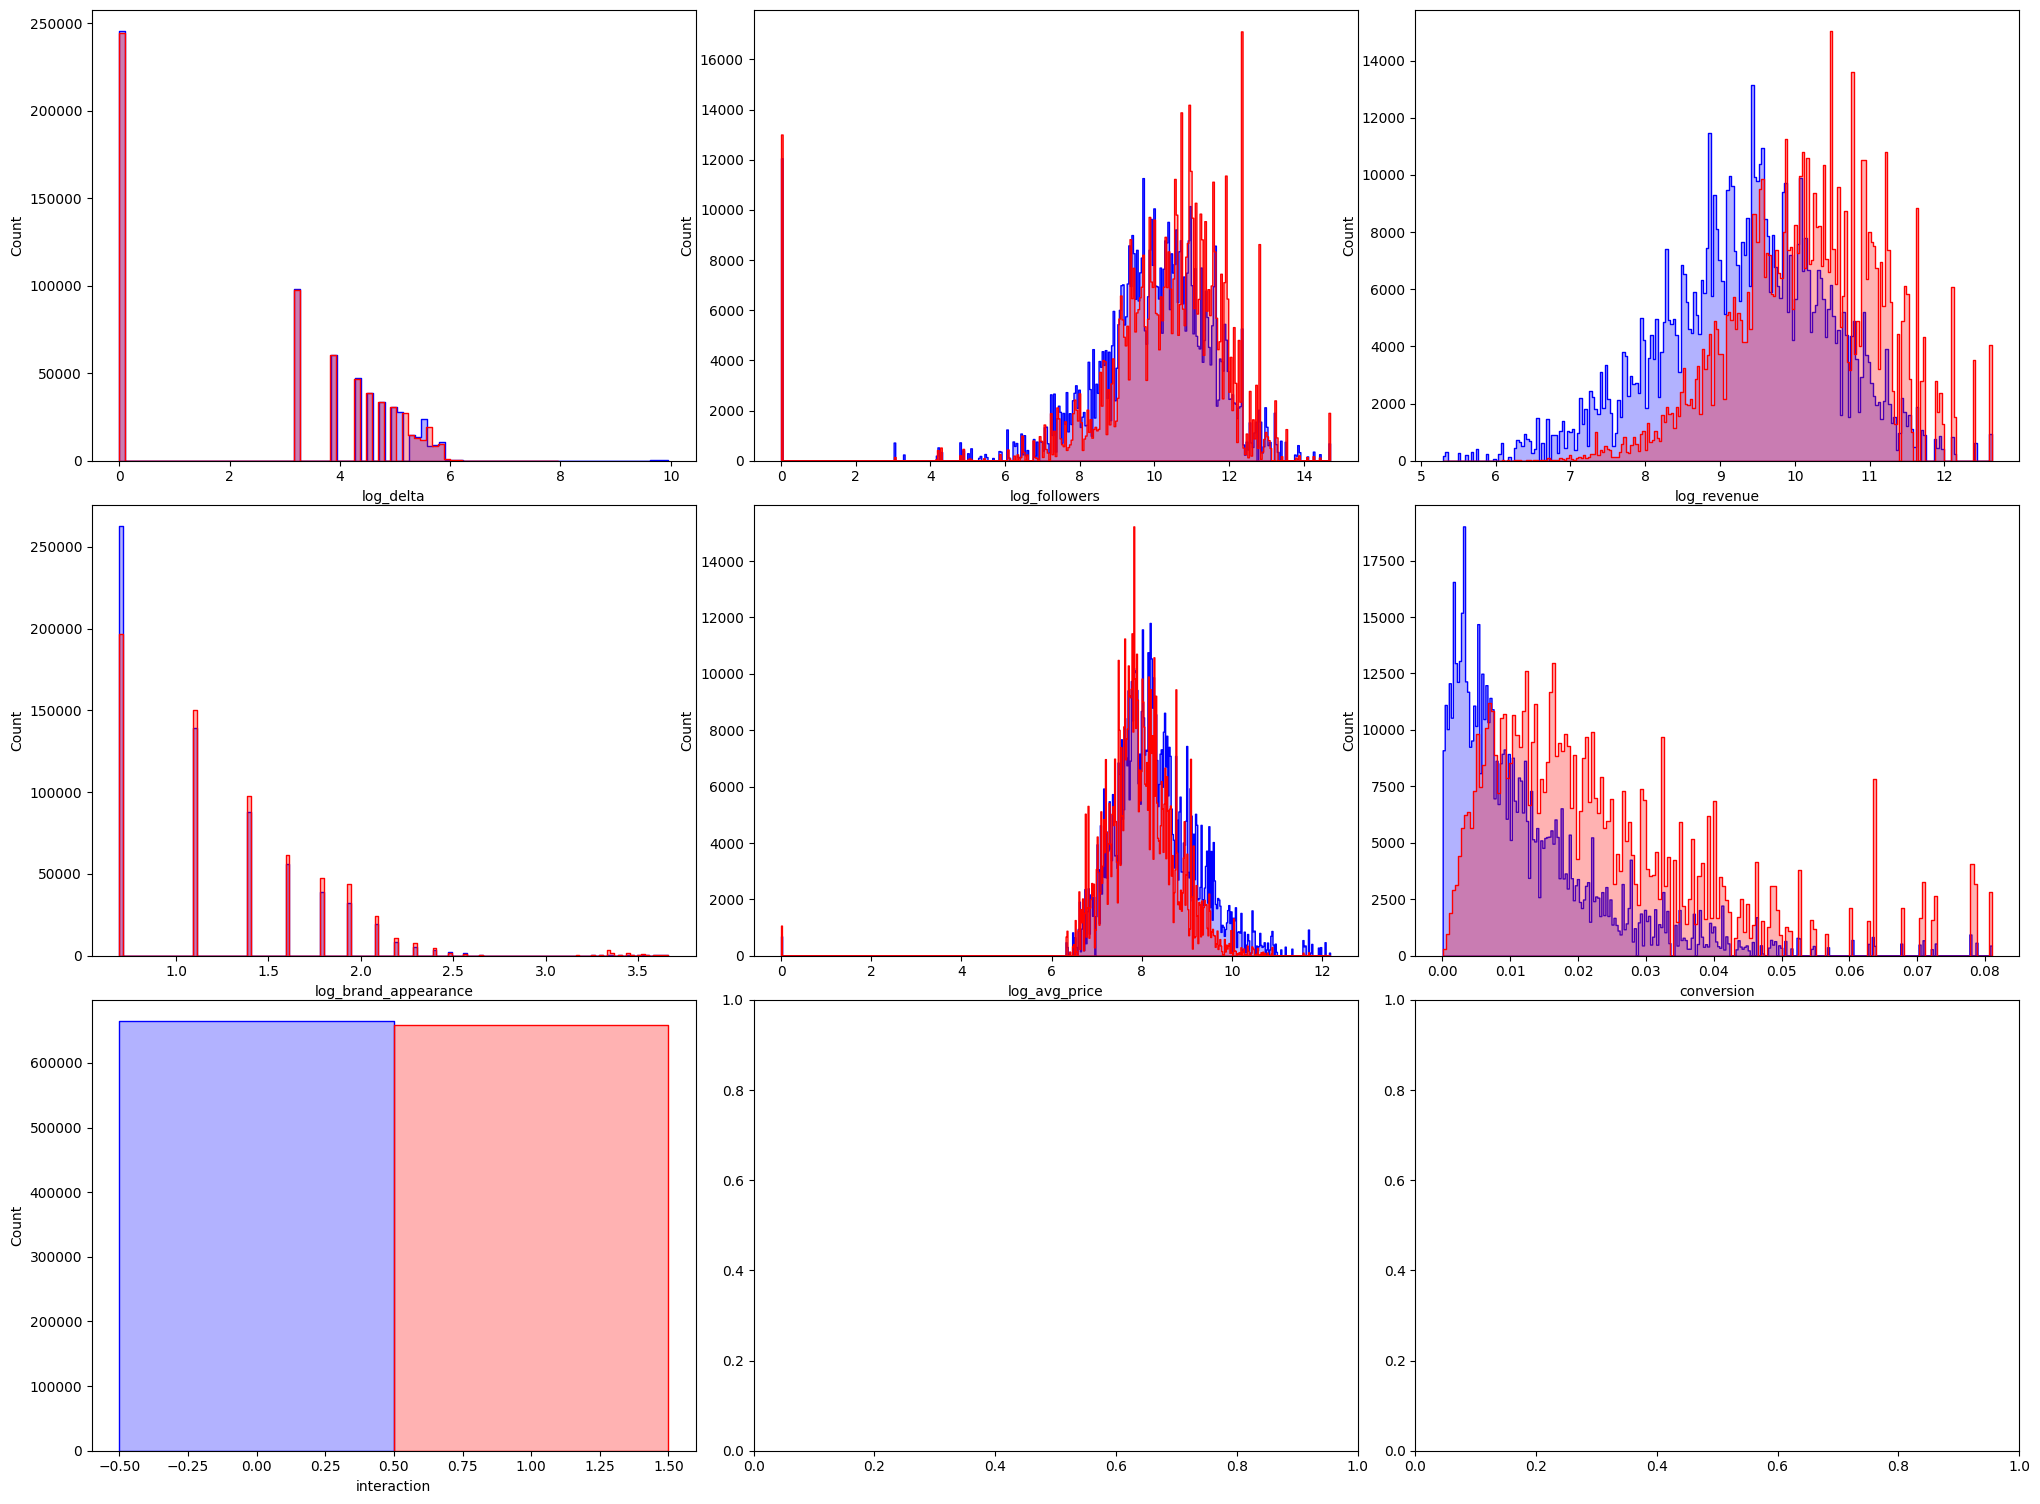

In [88]:
# Shows the distribution after processing with log
X= lognum_train_data

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(1, len(X.columns)), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

## Scalling

In order to deal with the different orders of magnitude of the features, the numerical columns are scaled. The scaler is saved and will be used for the preprocessing of future information.

In [89]:
def scale_sale(train: pd.DataFrame, test: pd.DataFrame, numerical_columns: list):
    """
    Returns dataframe with the given columns scaled.
    """
    new_train = train.__deepcopy__()
    new_test = test.__deepcopy__()

    num_train_data = new_train[numerical_columns]
    num_test_data = new_test[numerical_columns]

    scaler = StandardScaler()
    scaler.fit(num_train_data)

    new_train[numerical_columns] = scaler.transform(num_train_data)
    new_test[numerical_columns] = scaler.transform(num_test_data)
    
    pickle.dump(scaler, open('scaler_sales.sav', 'wb'))

    return (new_train, new_test)

In [90]:
numscaled_train, numscaled_test = scale_sale(lognum_train_data,
                                            lognum_test_data,
                                            NUMERICAL_FEATURES)

<Axes: >

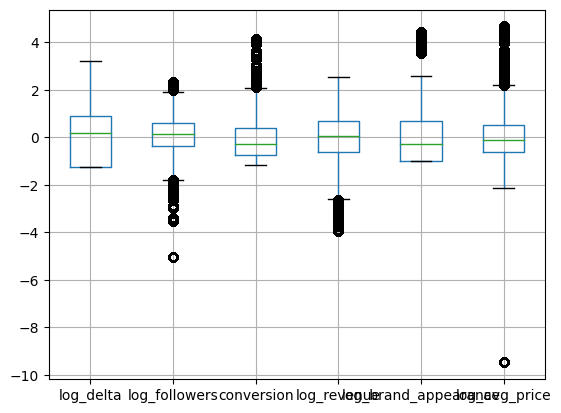

In [91]:
numscaled_train[NUMERICAL_FEATURES].boxplot()

# User data
This part focuses on the sme aspects as the sales' but for user information :
- monetary : the average amount by order of the user
- frequency: amount of time since firqt order/ number of orders
- recency: time since last order

In [92]:
user_data_train = scored_train_data[['user_key', 'monetary', 'frequency', 'recency', 'interaction']]
user_data_test = scored_test_data[['user_key', 'monetary', 'frequency', 'recency', 'interaction']]

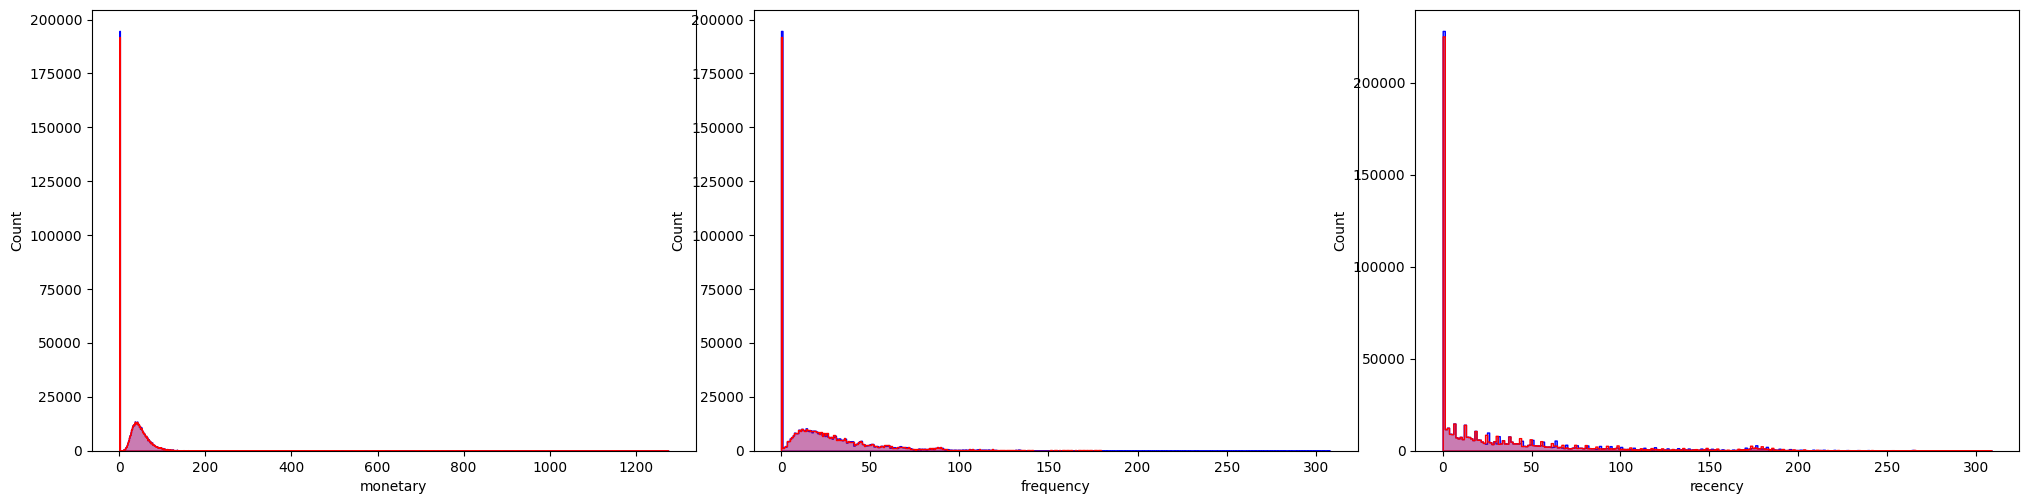

In [93]:
X = user_data_train

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
fig.tight_layout()

for i, ax in zip(range(1, len(X.columns)), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

In [94]:
loguser_train_data = adding_log(user_data_train, USER_FEATURES)
loguser_test_data = adding_log(user_data_test, USER_FEATURES)

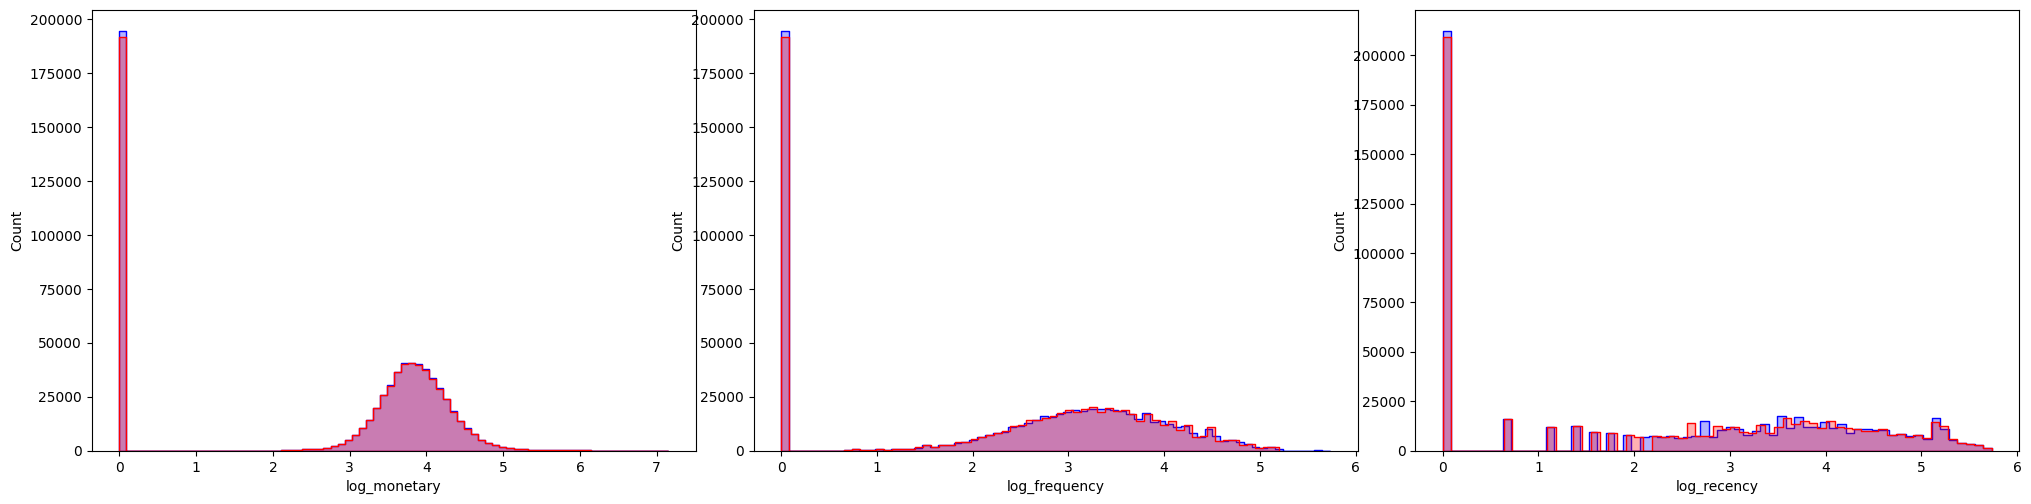

In [95]:
X = loguser_train_data

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
fig.tight_layout()

for i, ax in zip(range(1, len(X.columns)), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

## Scalling

In [96]:
def scale_user(train: pd.DataFrame, test: pd.DataFrame, columns: list):
    """
    Returns dataframe with the given columns scaled.
    """
    new_train = train.__deepcopy__()
    new_test = test.__deepcopy__()

    num_train_data = new_train[columns]
    num_test_data = new_test[columns]

    scaler_user = StandardScaler()
    scaler_user.fit(num_train_data)

    new_train[columns] = scaler_user.transform(num_train_data)
    new_test[columns] = scaler_user.transform(num_test_data)
    
    pickle.dump(scaler_user, open('scaler_user.sav', 'wb'))

    return (new_train, new_test)


In [97]:
userscaled_train, userscaled_test = scale_user(loguser_train_data[['user_key','log_monetary', 'log_frequency', 'log_recency']],
                                            loguser_test_data[['user_key', 'log_monetary', 'log_frequency', 'log_recency']],
                                            ['log_monetary', 'log_frequency', 'log_recency'])

<Axes: >

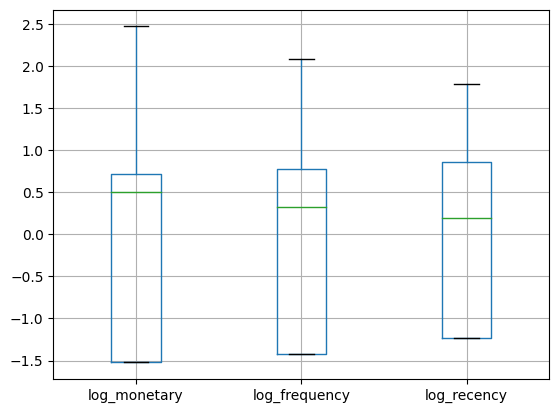

In [98]:
userscaled_train.boxplot()

# Creation of training DataFrame

In [99]:
user_categorical_test =  scored_test_data[['category_1', 'category_2', 'category_3']]
user_categorical_train= scored_train_data[['category_1', 'category_2', 'category_3']]

In [100]:
complete_test_data = pd.concat([userscaled_test, dummies_badges_test, dummies_category_test, numscaled_test, user_categorical_test], axis=1)
complete_train_data = pd.concat([userscaled_train,dummies_badges_train, dummies_category_train, numscaled_train, user_categorical_train], axis=1)

In [101]:
complete_test_data.to_csv('preped_test_data.csv')
complete_train_data.to_csv('preped_train_data.csv')

In [102]:
complete_test_data.columns

Index(['user_key', 'log_monetary', 'log_frequency', 'log_recency', 'artisanal',
       'b_corporation', 'bio', 'biodegradable', 'cadeau_ideal',
       'concept_original', 'durable', 'eco_friendly', 'excellent_sur_yuka',
       'exclusivite_choose', 'fabrication_a_la_demande', 'fait_main',
       'gluten_free', 'iconique', 'inclusive', 'innovation', 'made_in_europe',
       'made_in_france', 'madeinjapan', 'naturel', 'oeko_tex', 'premium',
       'recyclable', 'saint_valentin', 'savoir_faire', 'seconde_main',
       'socialement_engagee', 'serie_limitee', 'tendance', 'upcycling',
       'vegan', 'vintage', 'zerodechet', 'category_sale', 'sale_id',
       'log_delta', 'log_followers', 'log_revenue', 'log_brand_appearance',
       'log_avg_price', 'conversion', 'interaction', 'category_1',
       'category_2', 'category_3'],
      dtype='object')